In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import scipy as sp
import scipy.signal

import networkx as nx

import itertools
import string
import pickle
import glob
import os
import re 

import tqdm.notebook as tqdm

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils.pac import morph_cohort_pac_heatmap, PacSignificanceFunctor, morph_electrode_counter, compute_noise_with_notch, get_length_by_cdf
from utils.surf import create_adjacency, convert_matrix_indices
from utils.io import read_seeg_parcel_names, fix_mop, is_bipolar
from utils.vis_3d import BrainSurface
from utils.stats import bootstrap_statistic, nanpearson, corr_distance
from utils.fooof_utils import get_foofed_spectrum_chanwise
from utils.pyutils import convert_to_array
from utils.plot import draw_four_views
from utils.colors import okabe, ripples_blue, ripples_orange, ripples_red
from utils.surf import smooth_adjacent_values
from utils.clusters import danmf, filter_small_communities, get_communities_prob_threshold, filter_out_distance_matrix, remove_small_communities

%config InlineBackend.figure_format = 'jpg'

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)
mpl.rc('font', family='sans-serif') 

In [4]:
def load_psd_data(root_path, subject_number):
    fpath = os.path.join(root_path, 'SEEG', 'psd_statistics',  f'sub-{subject_number}_spectrum.pickle')
    return pickle.load(open(fpath, 'rb'))

In [5]:
submission_data_path = os.path.join('..', '..', 'meso_submission_data')
fsaverage_path = os.path.join(submission_data_path, 'anatomy', 'fsaverage')

In [6]:
n_cortical = 400
lags_cycles = np.arange(200)/10

In [7]:
seeg_parcels_dirpath = os.path.join(submission_data_path, 'SEEG')
seeg_parcel_names = read_seeg_parcel_names(n_cortical, root=seeg_parcels_dirpath)
unk_idx = [idx for (idx, n) in enumerate(seeg_parcel_names[-402:]) if ('unknown' in n.lower()) or ('background' in n.lower())]

In [8]:
adjacency_matrix = np.load(os.path.join(submission_data_path, 'SEEG', 'adjacency_matrix.npy'))

In [9]:
f_vals = [2]

while f_vals[~0] < 99:
    f_vals.append(f_vals[~0]*1.05)

f_vals = np.array(f_vals)

In [10]:
cohort_seeg_pac_values = np.load(os.path.join(submission_data_path, 'SEEG', 'cohort_seeg_pac_values.npy'))
cohort_seeg_pac_significant = np.load(os.path.join(submission_data_path, 'SEEG', 'cohort_seeg_pac_significant.npy'))

cohort_seeg_pac_known = np.delete(cohort_seeg_pac_values[:, -402:], unk_idx, axis=1)
cohort_seeg_pac_known_significant = np.delete(cohort_seeg_pac_significant[:, -402:], unk_idx, axis=1)

seeg_pac_values = np.nanmean(cohort_seeg_pac_values, axis=0)
seeg_pac_significant = np.nanmean(cohort_seeg_pac_significant, axis=0)

known_pac_significant = np.delete(seeg_pac_significant[-402:], unk_idx, axis=0)
known_pac_values = np.delete(seeg_pac_values[-402:], unk_idx, axis=0)

sign_ratio_boot = bootstrap_statistic(cohort_seeg_pac_known_significant)

seeg_ratio_mean = np.nanmean(sign_ratio_boot, axis=(0,1))
seeg_ratio_ci = np.nanpercentile(np.nanmean(sign_ratio_boot, axis=1), (5,95), axis=0)

C:\Users\vlamyr\AppData\Local\Temp\5\ipykernel_6700\3267956719.py:7: RuntimeWarning: Mean of empty slice
  seeg_pac_values = np.nanmean(cohort_seeg_pac_values, axis=0)
C:\Users\vlamyr\AppData\Local\Temp\5\ipykernel_6700\3267956719.py:8: RuntimeWarning: Mean of empty slice
  seeg_pac_significant = np.nanmean(cohort_seeg_pac_significant, axis=0)
l:\nttk-data3\palva\Vlad\projects_backup\seeg_meso_submission\utils\stats.py:90: RuntimeWarning: Mean of empty slice
  res[i] = func_object(xp.take(arr, round_idx, axis=axis), axis=axis)


In [11]:
counter_known = np.load(os.path.join(submission_data_path, 'SEEG', 'counter_known.npy'))

In [12]:
known_pac_values_smoothed = np.array([smooth_adjacent_values(vals, counter_known, adjacency_matrix) for vals in known_pac_values.T]).T

In [13]:
noise_level = np.load(os.path.join(submission_data_path, 'SEEG', 'seeg_noise_level.npy'))
meg_noise_with_notch = np.load(os.path.join(submission_data_path, 'MEG', 'meg_noise_level.npy'))

In [14]:
yeo7_to_17_mapping_fname  = os.path.join(submission_data_path, 'MEG', '7_to_17_400.csv')
yeo7_to_17_mapping_df  = pd.read_csv(yeo7_to_17_mapping_fname, header=None, sep=';')

yeo17_orig_ch_names = [n.split('-')[0] for n in yeo7_to_17_mapping_df[2]]

In [15]:
meg_pac_data = pickle.load(open(os.path.join(submission_data_path, 'figure_3', 'meg_pac_data.pickle'), 'rb'))

meg_psd_foofed = meg_pac_data['meg_psd_foofed']
meg_pac_subjectwise = meg_pac_data['meg_pac_subjectwise']
meg_parcel_names = meg_pac_data['parcel_names']

meg_psd_foofed_avg = meg_psd_foofed.mean(axis=0)

meg_pac_sign = (meg_pac_subjectwise >= meg_noise_with_notch.reshape(1,-1,1)).mean(axis=0)
meg_average_pac = meg_pac_subjectwise.mean(axis=0)

In [16]:
meg_ratio_individual = (meg_pac_subjectwise >= meg_noise_with_notch.reshape(1,-1,1))
meg_ratio_boot = bootstrap_statistic(meg_ratio_individual)

meg_ratio_mean = meg_ratio_boot.mean(axis=(0,-1))
meg_ratio_mean_parcelwise = meg_ratio_boot.mean(axis=0)
meg_ratio_ci = np.percentile(np.mean(meg_ratio_boot, axis=-1), (5,95), axis=0)

In [17]:
meg_pac_val_similarity_freq_both = 1 - sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_average_pac, metric=corr_distance))
meg_psd_val_similarity_freq_both = 1 - sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_psd_foofed_avg, metric=corr_distance))

meg_pac_val_corr_freq_both = 1 - sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_average_pac, metric='correlation'))


In [18]:
meg_pac_sign_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_pac_sign, metric=lambda *args: nanpearson(*args)[0]))
meg_pac_sign_similarity_freq_both[np.isnan(meg_pac_sign_similarity_freq_both)] = 0.0

meg_psd_val_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_psd_foofed_avg, metric=lambda *args: nanpearson(*args)[0]))

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [19]:
pac_val_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(known_pac_values.T, metric=corr_distance))

pac_val_corr_freq_smoothed_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(known_pac_values_smoothed.T, metric=lambda *args: nanpearson(*args)[0]))
pac_sign_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(known_pac_significant.T, metric=lambda *args: nanpearson(*args)[0]))


In [20]:
pac_val_corr_distance = np.sqrt(1 - pac_val_corr_freq_smoothed_both)/np.sqrt(2)
meg_pac_val_corr_distance = np.sqrt(1 - meg_pac_val_corr_freq_both)/np.sqrt(2)

distant_freqs_mask = np.abs(np.arange(81).reshape(1,-1) - np.arange(81).reshape(-1,1)) > 10
similar_freqs_mask = (pac_val_corr_distance > 0.58)

similarity_mask_combined = distant_freqs_mask | similar_freqs_mask
similarity_mask_cleared = ~remove_small_communities(~similarity_mask_combined)

pac_val_corr_distance_filtered = 1 - pac_val_corr_distance.copy()
pac_val_corr_distance_filtered[similarity_mask_cleared] = 0.0

In [21]:
upper_indices = np.triu_indices(81, 1)

surr_freq_fpath = os.path.join(submission_data_path, 'figure_3', 'surr_freq_corr_values.npy')

if os.path.exists(surr_freq_fpath):
    surr_freq_corr_values = np.load(surr_freq_fpath)
else:
    surr_freq_corr_values = compute_surr_freq_correlation(known_pac_values, n_rounds=1000)
    np.save(surr_freq_fpath, surr_freq_corr_values)

surr_freq_corr_values_flat = np.array([v[upper_indices] for v in surr_freq_corr_values])
surr_freq_dist_values_flat = np.sqrt(1 - surr_freq_corr_values_flat)/np.sqrt(2)

sign_dist_threshold = np.percentile(surr_freq_dist_values_flat.min(axis=-1), 1)

In [22]:
pac_val_corr_distance = np.sqrt(1 - pac_val_corr_freq_smoothed_both)/np.sqrt(2)
meg_pac_val_corr_distance = np.sqrt(1 - meg_pac_val_corr_freq_both)/np.sqrt(2)

distant_freqs_mask = np.abs(np.arange(81).reshape(1,-1) - np.arange(81).reshape(-1,1)) > 10
similar_freqs_mask = pac_val_corr_distance > sign_dist_threshold

similarity_mask_combined = distant_freqs_mask | similar_freqs_mask
similarity_mask_cleared = ~remove_small_communities(~similarity_mask_combined)

pac_val_corr_distance_filtered = 1 - pac_val_corr_distance.copy()
pac_val_corr_distance_filtered[similarity_mask_cleared] = 0.0

In [23]:
meg_pac_val_corr_distance_filtered = filter_out_distance_matrix(meg_pac_val_corr_distance, sign_dist_threshold, 10, min_size=10)

In [24]:
G = nx.from_numpy_array(pac_val_corr_distance_filtered)
coms = danmf(G, layers=[64,10], lamb=0.1, iterations=1000, pre_iterations=1000)
seeg_communities = filter_small_communities(get_communities_prob_threshold(coms.method_parameters['fitted_model']), seeg_ratio_mean)
seeg_communities = sorted(seeg_communities, key=lambda x: f_vals[x].mean())

G = nx.from_numpy_array(meg_pac_val_corr_distance_filtered)
meg_coms = danmf(G, layers=[64,16], lamb=0.1, iterations=1000, pre_iterations=1000)
meg_communities = filter_small_communities(meg_coms.communities, meg_ratio_mean, min_size=2, sign_threshold=0.02)
meg_communities = sorted(meg_communities, key=lambda x: f_vals[x].mean())

np.fill_diagonal(pac_val_corr_freq_smoothed_both, 1.0)

In [25]:
brain_anatomy = pickle.load(open(os.path.join(submission_data_path, 'anatomy', 'brain_anatomy.pickle'), 'rb'))

brain_surf_lh = brain_anatomy['lh']
brain_surf_rh = brain_anatomy['rh']

surf_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]

brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]

seeg_pidx_sorted = np.argsort(surf_parcel_names)

In [26]:
parcel_cohort_idx = np.argsort(known_pac_significant[:, :62].argmax(axis=1) - np.any(np.isnan(known_pac_significant), axis=1))

meg_cohort_idx = meg_pac_sign[:60].argmax(axis=0).argsort()

C:\Users\vlamyr\AppData\Local\Temp\5\ipykernel_6700\1449549140.py:61: RuntimeWarning: Mean of empty slice
  values = np.nanmean(data[:, indices], axis=-1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


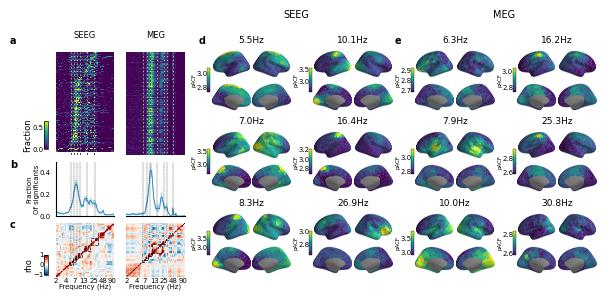

In [27]:
fig = plt.figure(figsize=(7,3))
main_spec = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1,3], wspace=0.1)

gs_0 = main_spec[0].subgridspec(3,2, hspace=0.1, height_ratios=[2,1,1])
gs_brain_cols = main_spec[1].subgridspec(nrows=3, ncols=4, hspace=0.2, wspace=0.25)

axes = np.empty((12,10), dtype=object)

axes[0,0] = fig.add_subplot(gs_0[0, 0])
axes[0,1] = fig.add_subplot(gs_0[0, 1])
axes[2,0] = fig.add_subplot(gs_0[1, 0])
axes[2,1] = fig.add_subplot(gs_0[1, 1])
axes[3,0] = fig.add_subplot(gs_0[2, 0])
axes[3,1] = fig.add_subplot(gs_0[2, 1])


for i,j in itertools.product(range(3), range(4)):
    brain_gs = gs_brain_cols[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc+2] = fig.add_subplot(brain_gs[nr,nc])
        
imh_seeg = axes[0,0].pcolormesh(f_vals, np.arange(400), known_pac_significant[parcel_cohort_idx], cmap='viridis', vmax=0.65, rasterized=True)
imh_meg = axes[0,1].pcolormesh(f_vals, np.arange(400), meg_pac_sign[:, meg_cohort_idx].T, cmap='viridis', vmax=0.65, rasterized=True)

axes[0,0].set_xscale('log')
axes[0,1].set_xscale('log')

axes[2,0].semilogx(f_vals, seeg_ratio_mean, lw=0.5)
axes[2,0].fill_between(f_vals, *seeg_ratio_ci, alpha=0.25)

axes[2,1].semilogx(f_vals, meg_ratio_mean, lw=0.5)

axes[2,1].fill_between(f_vals, *meg_ratio_ci, alpha=0.25)

cax_seeg =  inset_axes(axes[0,0],
                 width="10%",  # width = 10% of parent_bbox width
                 height="25%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(-0.2, 0.05, 0.8, 1.05),
                 bbox_transform=axes[0,0].transAxes,
                 borderpad=0,
                 )

seeg_cbar = fig.colorbar(imh_seeg, cax=cax_seeg, orientation='vertical')
seeg_cbar.outline.set_linewidth(0.5)

for i in range(6):   
    for type_idx, modality, mapper, data in zip(range(2), ['SEEG', 'MEG'], 
                            [seeg_communities, meg_communities],
                            [known_pac_values[seeg_pidx_sorted], meg_average_pac[:, np.argsort(meg_parcel_names)].T]):


                                
        row_idx = (i % 3)
        col_idx = (i // 3) + type_idx*2

        is_seeg = (modality == 'SEEG')
        indices = mapper[i]
        center_frequency = f_vals[indices].mean()

        values = np.nanmean(data[:, indices], axis=-1)
        cmap_name = 'viridis'
        norm_values = None
        
        if is_seeg:
            values = smooth_adjacent_values(values, counter_known[seeg_pidx_sorted], adjacency_matrix[seeg_pidx_sorted][:, seeg_pidx_sorted])
            values = np.clip(values, 0.0, np.nanpercentile(values, 99))  
            
        vmin = values.min()
        vmax = values.max()

        norm_values = (vmin, vmax)
        
        to_plot_axes = axes[row_idx*2:(row_idx+1)*2, (col_idx+1)*2:(col_idx+2)*2]

        cbar_ax_kwargs = {'bbox_to_anchor':(-0.25,0.35,0.7,1.35), }

        draw_four_views(to_plot_axes, values, sorted(surf_parcel_names), brain_3d_surfaces, 
                    cbar_ax_kwargs=cbar_ax_kwargs, cmap=cmap_name, norm_values=norm_values)

        cbar_ax = fig.axes[~0]
        
        title = f'{round(center_frequency, 1)}Hz'
        title_x = 1.0
            
        to_plot_axes[0,0].set_title(title, x=title_x, y=0.9, fontsize=6.5)
        

imh0 = axes[3,0].pcolormesh(f_vals, f_vals, pac_val_corr_freq_smoothed_both, cmap='RdBu_r', vmax=1, vmin=-1, rasterized=True)
imh2 = axes[3,1].pcolormesh(f_vals, f_vals, meg_pac_val_corr_freq_both, cmap='RdBu_r', vmax=1, vmin=-1, rasterized=True)

for comm in seeg_communities:
    center_freq = f_vals[comm].mean()
    
    s, e = f_vals[min(comm)], f_vals[max(comm)]
    
    r = plt.Rectangle([s,s], e-s, e-s, facecolor='none', edgecolor='black', ls='--', lw=0.5)
    axes[3,0].add_patch(r)   
    
    axes[3,0].vlines([center_freq], center_freq, 100, color='white',lw=0.5)
    axes[0,0].vlines([center_freq], 0, 400, color='white', lw=0.5)
    
    axes[3,0].vlines([center_freq], center_freq, 100, color='black', ls='--', lw=0.25)
    axes[2,0].vlines([center_freq], 0, 1, ls='--', color='black', lw=0.25)
    axes[0,0].vlines([center_freq], 0, 400, ls='--', color='black', lw=0.5)
    
for comm in meg_communities:
    center_freq = f_vals[comm].mean()
    s, e = f_vals[min(comm)], f_vals[max(comm)]
    
    r = plt.Rectangle([s,s], e-s, e-s, facecolor='none', edgecolor='black', ls='--', lw=0.5)
    axes[3,1].add_patch(r)  
    
    axes[3,1].vlines([center_freq], center_freq, 100, color='white', lw=0.5)
    axes[0,1].vlines([center_freq], 0, 400, color='white', lw=0.5)
    
    axes[3,1].vlines([center_freq], center_freq, 100, color='black', ls='--', lw=0.25)
    axes[2,1].vlines([center_freq], 0, 1, ls='--', color='black', lw=0.25)
    axes[0,1].vlines([center_freq], 0, 400, ls='--', color='black', lw=0.5)
    
seeg_freq_cax = inset_axes(axes[3,0],
                 width="10%",  # width = 10% of parent_bbox width
                 height="35%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(-0.2, 0.05, 0.7, 1.05),
                 bbox_transform=axes[3,0].transAxes,
                 borderpad=0,
                 )
    
for ax, cax, imh, title in zip(axes[3,:2], [seeg_freq_cax, seeg_freq_cax], [imh0, imh0], ['pACF, LH', 'pACF, RH',]):
    cb = fig.colorbar(imh, cax=cax, orientation='vertical')
    cb.outline.set_linewidth(0.5)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xticks(np.round(np.geomspace(2, 90, 7)))
    ax.set_yticks([])
    
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    
    ax.minorticks_off()
    ax.tick_params(labelsize=5, pad=0.0, length=0.1)

    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Frequency (Hz)', fontsize=5, labelpad=0.0)
    
axes[3,1].set_yticks([])

cax_seeg.set_ylabel('Fraction', fontsize=6, labelpad=0.1)
seeg_freq_cax.set_ylabel('rho', fontsize=6, labelpad=0.1)

for ax in axes[2, :2].flatten().tolist():
    ax.set_xticks([])

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    ax.tick_params(labelsize=5, bottom=False, left=False, pad=0.0)
    
    ax.set_ylabel('Fraction\nOf significants', fontsize=5, labelpad=0.0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim([f_vals[0], f_vals[~0]])
    ax.set_ylim([0, 0.5])

    
for ax in axes[0, :2]:
    ax.set_xticks([])

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    ax.set_yticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.tick_params(labelsize=5, bottom=False, left=False, pad=0.0)

for ax in [cax_seeg, seeg_freq_cax]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

axes[0,0].set_title('SEEG', fontsize=6)
axes[0,1].set_title('MEG', fontsize=6)

fig.text(0.45, 0.975, 'SEEG', fontsize=7)
fig.text(0.75, 0.975, 'MEG', fontsize=7)
    
axes[2,1].spines['left'].set_visible(False)
axes[2,1].set_yticks([])
axes[2,1].set_ylabel('')

cax_seeg.yaxis.set_ticks_position('left')
cax_seeg.yaxis.set_label_position('left')

seeg_freq_cax.yaxis.set_ticks_position('left')
seeg_freq_cax.yaxis.set_label_position('left')

for ax in fig.axes[-13:-1]:
    ax.set_ylabel('pACF', fontsize=4, labelpad=0.0)
    ax.yaxis.set_label_position('left')
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.1f}"))


for ax in fig.axes[-13:-1] + [cax_seeg, seeg_freq_cax]:
    ax.tick_params(labelsize=5, pad=0.1, left=False, length=0.0)
      
axes[2,0].legend(fontsize=7, frameon=False)
        
ax_labels = [axes[0,0], axes[2,0], axes[3,0]]
ax_brain_labels = [axes[0,2], axes[2,2], axes[4,2], axes[0,6], axes[2,6], axes[4,6]]


for label, (xpos, ypos) in zip(string.ascii_lowercase, itertools.product([0.06], [0.89, 0.475, 0.275])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')

for label, (xpos, ypos) in zip(string.ascii_lowercase[3:], itertools.product([0.33, 0.61], [0.89])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')
    
fig.savefig('publication_figures/figure_3.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_3.{format}', dpi=300, bbox_inches="tight")

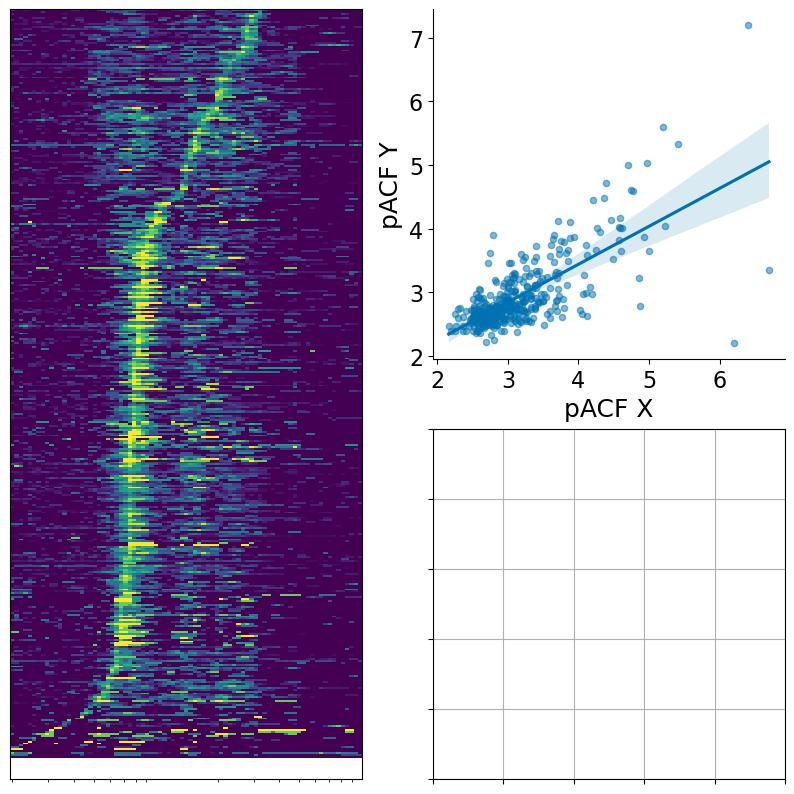

In [61]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(nrows=2, ncols=2)

ax_pacf = fig.add_subplot(gs[:, 0])
ax_hm = fig.add_subplot(gs[1,1])
ax_corr = fig.add_subplot(gs[0,1])

ax_pacf.pcolormesh(f_vals, np.arange(400), known_pac_significant[parcel_cohort_idx], cmap='viridis', vmax=0.65, rasterized=True)
ax_pacf.set_xscale('log')

# ax_corr.scatter(known_pac_values[:, 30], known_pac_values[:, 32], s=1, alpha=0.5)
sns.regplot(x=known_pac_values[:, 30], y=known_pac_values[:, 32], ax=ax_corr, scatter_kws={'s':20, 'alpha':0.5})
ax_hm.grid(True)

# ax_hm.set_xticks([])
# ax_hm.set_yticks([])

ax_hm.set_xticklabels([])
ax_hm.set_yticklabels([])

ax_pacf.set_xticks([])
ax_pacf.set_yticks([])

ax_corr.set_xlabel('pACF X', fontsize=18)
ax_corr.set_ylabel('pACF Y', fontsize=18)
ax_corr.tick_params(labelsize=16)

ax_corr.spines['top'].set_visible(False)
ax_corr.spines['right'].set_visible(False)

### Supplementary figure 3

In [62]:
cohort_seeg_psd_values = morph_cohort_pac_heatmap(data_parcels, cohort_psd_foofed, n_parcels=n_cortical + 93)
cohort_seeg_psd_known = np.delete(cohort_seeg_psd_values[:, -402:], unk_idx, axis=1)

seeg_psd_known = np.nanmean(cohort_seeg_psd_known, axis=0)

In [ ]:
psd_val_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(seeg_psd_known.T, metric=lambda *args: nanpearson(*args)[0]))
np.fill_diagonal(psd_val_similarity_freq_both, 1.0)

In [ ]:
meg_psd_significant_subjectwise = (meg_psd_foofed >= 0.5)
meg_psd_sign_boot = bootstrap_statistic(meg_psd_significant_subjectwise)

meg_psd_sign_mean = meg_psd_sign_boot.mean(axis=(0,-1))
meg_psd_sign_5, meg_psd_sign_95 = np.percentile(meg_psd_sign_boot.mean(axis=-1), (5,95), axis=0)

In [ ]:
cohort_seeg_psd_significant = np.load(os.path.join(submission_data_path, 'figure_3', 'cohort_seeg_psd_significant.npy'))

psd_sign_ratio_boot = bootstrap_statistic(cohort_seeg_psd_significant)

psd_sign_ratio_mean = np.nanmean(psd_sign_ratio_boot, axis=(0,1))
psd_sign_ratio_5, psd_sign_ratio_95 = np.percentile(np.nanmean(psd_sign_ratio_boot, axis=1), (5,95), axis=0)

l:\nttk-data3\palva\Vlad\projects_backup\seeg_meso_submission\utils\stats.py:90: RuntimeWarning: Mean of empty slice
  res[i] = func_object(xp.take(arr, round_idx, axis=axis), axis=axis)


In [ ]:
np.fill_diagonal(meg_psd_val_similarity_freq_both, 1.0)
np.fill_diagonal(pac_val_corr_distance, 0.0)

C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_30440\2436276957.py:51: RuntimeWarning: Mean of empty slice
  values = np.nanmean(data[:, indices], axis=-1)


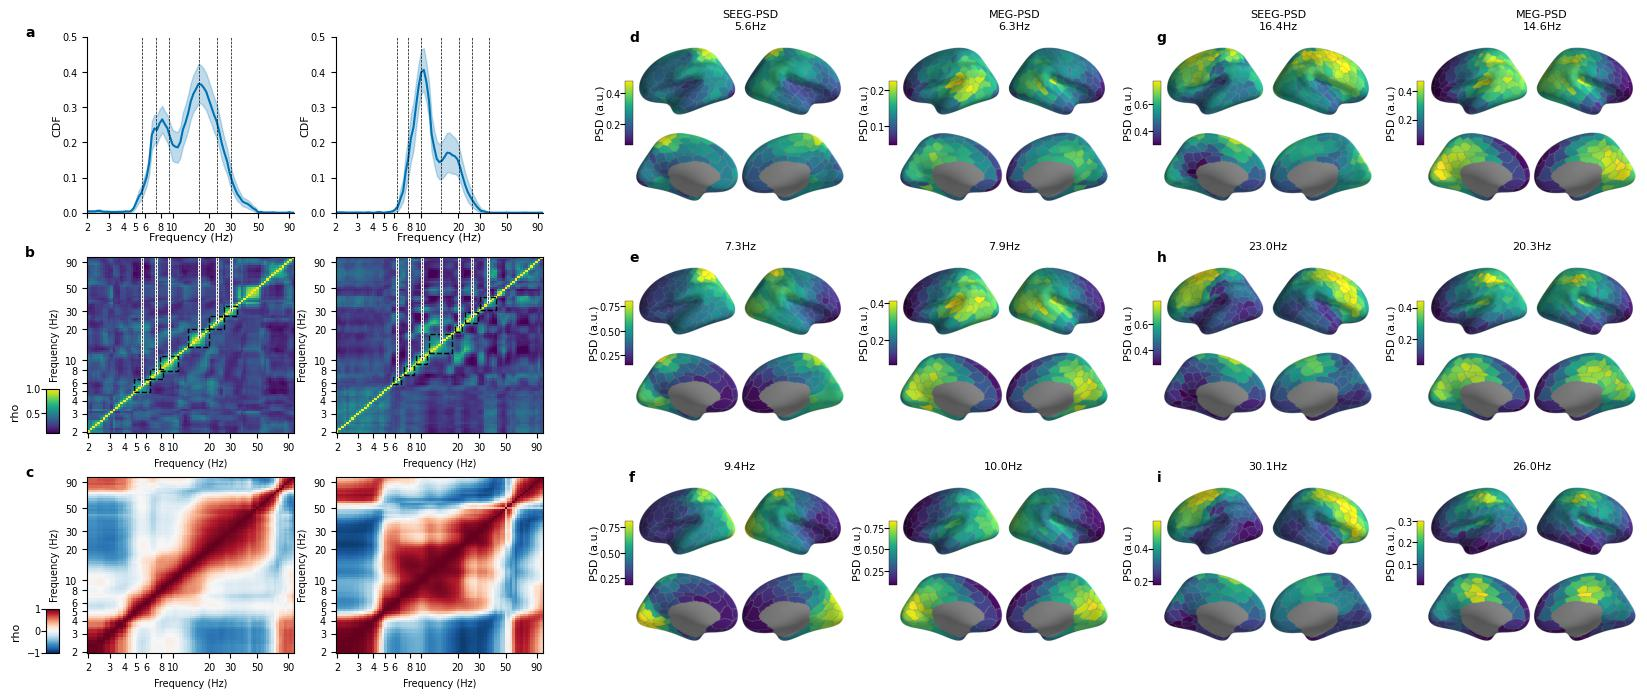

In [ ]:
fig = plt.figure(figsize=(20,8))
main_spec = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1,1,1])

gs_0 = main_spec[0].subgridspec(3,2, hspace=0.25)
gs_brain_cols = main_spec[1:].subgridspec(ncols=4, nrows=3, hspace=0.25, wspace=0.25)

axes = np.empty((8,12), dtype=object)

axes[0,0] = fig.add_subplot(gs_0[0, 0])
axes[0,1] = fig.add_subplot(gs_0[0, 1])
axes[1,0] = fig.add_subplot(gs_0[1, 0])
axes[1,1] = fig.add_subplot(gs_0[1, 1])
axes[2,0] = fig.add_subplot(gs_0[2, 0])
axes[2,1] = fig.add_subplot(gs_0[2, 1])

for i,j in itertools.product(range(3), range(4)):
    brain_gs = gs_brain_cols[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc+2] = fig.add_subplot(brain_gs[nr,nc])


seeg_meg_psd_freq_cax = inset_axes(axes[2,0],
                 width="8%",  # width = 10% of parent_bbox width
                 height="25%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(-0.2, 0.0, 0.8, 1),
                 bbox_transform=axes[2,0].transAxes,
                 borderpad=0,
                 )

corr_distance_freq_cax = inset_axes(axes[1,0],
                 width="8%",  # width = 10% of parent_bbox width
                 height="25%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(-0.2, 0.0, 0.8, 1),
                 bbox_transform=axes[1,0].transAxes,
                 borderpad=0,
                 )
        
for i in range(6):   
    for type_idx, modality, mapper, data in zip(range(2), ['SEEG', 'MEG'], 
                                [seeg_communities, meg_communities],
                                [seeg_psd_known[seeg_pidx_sorted], meg_psd_foofed_avg[:, np.argsort(yeo17_orig_ch_names)].T]):
        row_idx = (i % 3)
        col_idx = (i // 3)*2 + type_idx + 1

        is_seeg = (modality == 'SEEG')
        indices = mapper[i]
        center_frequency = f_vals[indices].mean()

        values = np.nanmean(data[:, indices], axis=-1)
        cmap_name = 'viridis'
        norm_values = None
        
        if is_seeg:
            values = smooth_adjacent_values(values, counter_known[seeg_pidx_sorted], adjacency_matrix[seeg_pidx_sorted][:, seeg_pidx_sorted])
            values = np.clip(values, 0.0, np.nanpercentile(values, 99))  
            
        vmin = values.min()
        vmax = values.max()

        norm_values = (vmin, vmax)
        
        to_plot_axes = axes[row_idx*2:(row_idx+1)*2, col_idx*2:(col_idx+1)*2]

        draw_four_views(to_plot_axes, values, sorted(surf_parcel_names),
                        brain_3d_surfaces, cmap=cmap_name, norm_values=norm_values)

        cbar_ax = fig.axes[~0]
        
        if row_idx == 0:
            title = f'{modality}-PSD\n{round(center_frequency, 1)}Hz'
            title_x  = 1.1
        else:
            title = f'{round(center_frequency, 1)}Hz'
            title_x = 1.0
            
        to_plot_axes[0,0].set_title(title, x=title_x, y=1.05, fontsize=8)

axes[0,0].semilogx(f_vals, psd_sign_ratio_mean, color=ripples_blue)
axes[0,0].fill_between(f_vals, psd_sign_ratio_5, psd_sign_ratio_95, color=ripples_blue, alpha=0.25)

axes[0,1].semilogx(f_vals, meg_psd_sign_mean, color=ripples_blue)
axes[0,1].fill_between(f_vals, meg_psd_sign_5, meg_psd_sign_95, color=ripples_blue, alpha=0.25)

imh0 = axes[1,0].pcolormesh(f_vals, f_vals, 1 - pac_val_corr_distance, cmap='viridis', vmax=1, vmin=0.1)
axes[1,1].pcolormesh(f_vals, f_vals, 1 - meg_pac_val_corr_distance, cmap='viridis', vmax=1, vmin=0.1)

imh1 = axes[2,0].pcolormesh(f_vals, f_vals, psd_val_similarity_freq_both, cmap='RdBu_r', vmax=1, vmin=-1)
axes[2,1].pcolormesh(f_vals, f_vals, meg_psd_val_similarity_freq_both, cmap='RdBu_r', vmax=1, vmin=-1)

for comm in seeg_communities:
    center_freq = f_vals[comm].mean()
    
    s, e = f_vals[min(comm)], f_vals[max(comm)]
    
    r = plt.Rectangle([s,s], e-s, e-s, facecolor='none', edgecolor='black', ls='--')
    axes[1,0].add_patch(r)   
    
    axes[1,0].vlines([center_freq], center_freq, 100, color='white',lw=2)
    axes[1,0].vlines([center_freq], center_freq, 100, color='black', ls='--', lw=0.5)

    axes[0,0].vlines([center_freq], 0, 1, ls='--', color='black', lw=0.5)
    
for comm in meg_communities:
    center_freq = f_vals[comm].mean()
    s, e = f_vals[min(comm)], f_vals[max(comm)]
    
    r = plt.Rectangle([s,s], e-s, e-s, facecolor='none', edgecolor='black', ls='--')
    axes[1,1].add_patch(r)  
    
    axes[1,1].vlines([center_freq], center_freq, 100, color='white', lw=2)
    axes[1,1].vlines([center_freq], center_freq, 100, color='black', ls='--', lw=0.5)

    axes[0,1].vlines([center_freq], 0, 1, ls='--', color='black', lw=0.5)
  

for ax in axes[0,:2]:    
    ax.set_xscale('log')

    ax.set_xticks([2,3,4,5,6,8,10,20,30, 50, 90])
    
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.set_xlabel('Frequency (Hz)', fontsize=8, labelpad=0.0)
    ax.set_ylabel('CDF', fontsize=8, labelpad=0.0)

    ax.minorticks_off()
    ax.tick_params(labelsize=7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(f_vals[[0,~0]])
    ax.set_ylim([0,0.5])
        
for ax in axes[1:3,:2].flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xticks([2,3,4,5,6,8,10,20,30, 50, 90])
    ax.set_yticks([2,3,4,5,6,8,10,20,30, 50, 90])
    
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    
    ax.minorticks_off()
    ax.tick_params(labelsize=7)

    ax.set_xlabel('Frequency (Hz)', fontsize=7)
    ax.set_ylabel('Frequency (Hz)', fontsize=7)
    
fig.colorbar(imh1, cax=seeg_meg_psd_freq_cax, orientation='vertical')
fig.colorbar(imh0, cax=corr_distance_freq_cax, orientation='vertical')

for ax, label in  zip(fig.axes[-12:], ['PSD (a.u.)']*12):
    ax.set_ylabel(label, fontsize=8, labelpad=0.0)
    ax.yaxis.set_label_position('left')

for ax in fig.axes[-14:]:
    ax.tick_params(labelsize=7, pad=0.0)
    
seeg_meg_psd_freq_cax.yaxis.set_label_text('rho', fontsize=8)
seeg_meg_psd_freq_cax.yaxis.set_label_position('left')
seeg_meg_psd_freq_cax.yaxis.set_ticks_position('left')

corr_distance_freq_cax.yaxis.set_label_text('rho', fontsize=8)
corr_distance_freq_cax.yaxis.set_label_position('left')
corr_distance_freq_cax.yaxis.set_ticks_position('left')

ax_labels = [axes[0,0], axes[1,0], axes[2,0]]
ax_brain_labels = [axes[0,2], axes[2,2], axes[4,2], axes[0,6], axes[2,6], axes[4,6]]

for ax, label in zip(ax_labels, 
                     string.ascii_lowercase):
    ax.text(-0.3, 1, label, fontsize=10, transform=ax.transAxes, weight='bold')
    
for ax, label in zip(ax_brain_labels, 
                     string.ascii_lowercase[3:]):
    ax.text(-0.05, 1, label, fontsize=10, transform=ax.transAxes, weight='bold')
      
fig.savefig('publication_figures/figure_3_supp.png', dpi=300, bbox_inches="tight")

### Animation of the pACF arhictecture for SEEG data

In [ ]:
raise RuntimeError('Stop before making the animation!')

RuntimeError: Stop before making the animation!

In [ ]:
import cv2
from utils.plot import get_img_from_fig

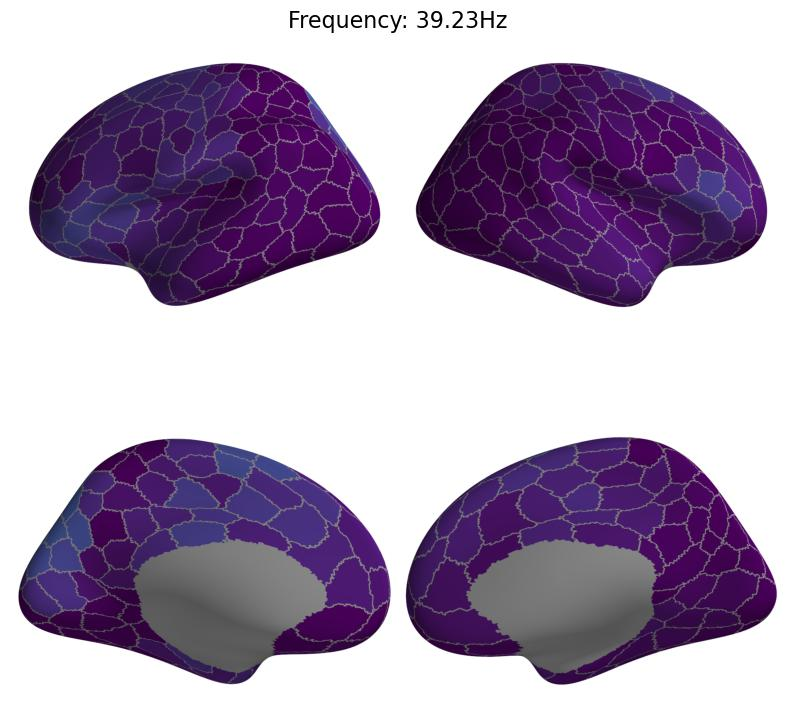

In [ ]:
images_list = list()

fig, axes = plt.subplots(figsize=(10,10), ncols=2, nrows=2, gridspec_kw={'hspace': 0.0, 'wspace': 0.0})

for freq_idx, freq in enumerate(f_vals[:62]):
    values = known_pac_significant[:, freq_idx]
    values = smooth_adjacent_values(values, counter_known, adjacency_matrix)

    values = np.clip(values, 0.0, np.nanpercentile(values, 99))  

#     vmin = values.min()
#     vmax = values.max()
    vmin = 0.0
    vmax = 0.6

    norm_values = (vmin, vmax)
    
    draw_four_views(axes, values, surf_parcel_names,
                    brain_3d_surfaces, cmap='viridis', norm_values=norm_values)
    axes[0,0].set_title(f'Frequency: {round(freq, 2)}Hz', x=1, fontsize=16)
    
    
    fig_array = get_img_from_fig(fig)
    images_list.append(fig_array)
    fig.axes[~0].remove()

In [ ]:
height, width, layers = images_list[0].shape
fps = 2
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') 

video = cv2.VideoWriter('pACF_movie_sign.mov', fourcc, fps, (width,height))

for image in images_list:
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    video.write(image_bgr)

cv2.destroyAllWindows()
video.release()

In [11]:
import matplotlib.pyplot as plt
from crosspy.preprocessing.signal import filter_data
from crosspy.core.stats import biExp, singleExp, _fit_exponents

In [15]:
def _compute_BiS_channel_mle(data) -> float: 
    
    '''
    INPUT: 
        data: power time-series
    OUTPUT: 
        - BiS: bistability index.
        
    The function returns BiS = 0 if single-exponential model is a more likely model for the observed time series, while the function returns BiS > 0 if the most likely model for the observed time series is the bi-exponential model.
    '''
    
    biexp_params, exp_params = _fit_exponents(data)
    
    gamma1, gamma2, delta1, delta2 = biexp_params
    
    gamma = exp_params
    
    loglike_biexp = np.sum(np.log(biExp.pdf(data, gamma1, gamma2, delta1, delta2)))
    loglike_exp = np.sum(np.log(singleExp.pdf(data, gamma)))

    nSamples = data.shape[0]
    k_biexp = len(biexp_params)  
    k_exp = 1 
    
    BIC_biexp = -2*loglike_biexp + k_biexp*np.log(nSamples)
    BIC_exp = -2*loglike_exp + k_exp*np.log(nSamples)

    deltaBIC = BIC_exp - BIC_biexp
    
    if deltaBIC > 0: 
        BiS = np.log10(deltaBIC)
    else:
        BiS = 0
    
    return BiS, BIC_exp, BIC_biexp

In [87]:
import cupy as cp
import numpy as np
import mne

from tqdm.notebook import tqdm
# from crosspy.core.criticality import _compute_BiS_channel_mle, compute_BiS_em
from crosspy.core.timeline import bis_wrapper
from crosspy.preprocessing.signal import filter_data
import math

# def create_frequency_axis(f_min=2, f_max= 4, num_wavelet = 10):
#     f_min_log = math.floor(np.log10(f_min))
#     f_max_log = math.ceil(np.log10(f_max))
#     mb = np.logspace(f_min_log, f_max_log, num=num_wavelet) # Morlet bank
#     freq_vals = mb[(2.1 < mb) & (mb < 90)] # Frequency of interest
#     freq_labels = [('%.2f'%x) for x in freq_vals]
#     return freq_vals, freq_labels

# data = np.load(r'C:\Users\vlamyr\Downloads\data.npy')
# freqs, _ = create_frequency_axis(2, 90, 40)

# bis_mle = np.zeros((len(freqs)))
# mle_bic_exp = np.zeros((len(freqs)))
# mle_bic_biexp = np.zeros((len(freqs)))

# for freq_idx, freq in tqdm(enumerate((freqs)), desc='Frequencies', unit='freqs', total=len(freqs)):

#     morlet = mne.time_frequency.tfr_array_morlet(np.expand_dims(data[1000:-1000], axis=(0, 1)), 512, freqs=[
#                                                  freq], n_cycles=5, verbose=False, output="complex").squeeze()
#     # morlet_cp = cp.array(morlet)
    
#     # bis_em[freq_idx] = bis_wrapper(cp.expand_dims(
#     #     morlet_cp, axis=0), max_iters=1000, min_delta=1e-5)
    
#     pwTS = np.abs(morlet)**2

#     pwTS /= pwTS.max(axis=-1, keepdims=True)

#     bis_mle[freq_idx], mle_bic_exp[freq_idx], mle_bic_biexp[freq_idx] = _compute_BiS_channel_mle(pwTS)

In [91]:
pwTS = np.random.exponential(size=5000)
pwTS /= pwTS.max()

In [92]:
_compute_BiS_channel_mle(pwTS)

(0, -10691.710153447151, -10666.15857319765)

In [73]:

    # gamma, _, _ = singleExp.fit(data, floc=0, fscale=1)

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [46]:
def _exp_pdf(x, a, g):
    return (a/g).reshape(-1,1)*np.exp(-1.0/g.reshape(-1,1)*x)

def _fit_biexp_em(x, max_iters: int=100, min_delta: float=0.1):
    def _compute_probs():
        numer = _exp_pdf(x, alpha, thetas[0])
        denom = numer + _exp_pdf(x, 1 - alpha, thetas[1])

        return numer/denom
    
    def _compute_nnlf():
        thetas_fixed = 1.0 / thetas
        
        return xp.sum( xp.log( _exp_pdf(x, alpha, thetas_fixed[0]) + _exp_pdf(x, 1 - alpha, thetas_fixed[1])), axis=-1)
    
    xp = cp
    n_chans, n = x.shape
    
    thetas = xp.zeros([2, n_chans])
    alpha = xp.full(n_chans, 0.4)

    thetas[0] = 2.0/x.mean(axis=-1)
    thetas[1] = 0.5/x.mean(axis=-1)

    alpha[:] = 0.4

    prev_nnlf = float(n)

    for i in range(max_iters):
        probs = _compute_probs()

        alpha = probs.sum(axis=-1)/n

        thetas[0] = 1/(n*alpha)*xp.sum(x*probs, axis=-1)
        thetas[1] = 1/(n*(1-alpha))*xp.sum(x*(1-probs), axis=-1)

        nnlf = _compute_nnlf()
        delta_nnlf = xp.abs(nnlf - prev_nnlf).mean()
        
        if(delta_nnlf < min_delta):
            break

        prev_nnlf = nnlf

    thetas = 1.0 / thetas
    return thetas, alpha

def compute_BiS_em(data, max_iters: int=100, min_delta: float=0.1):
    xp = cp
    n_samples = data.shape[-1]

    exp_params = 1.0/data.mean(axis=-1)
    thetas, alpha = _fit_biexp_em(data, max_iters=max_iters, min_delta=min_delta)

    nnlf_exp = xp.sum( xp.log( _exp_pdf(data, 1.0, 1.0/exp_params)), axis=-1)
    nnlf_biexp = xp.sum( xp.log( _exp_pdf(data, alpha, 1.0/thetas[0]) + _exp_pdf(data, 1 - alpha, 1.0/thetas[1])), axis=-1)
        
    bic_exp = -2*nnlf_exp + xp.log(n_samples)
    bic_biexp = -2*nnlf_biexp + 3*xp.log(n_samples)

    deltaBIC = bic_exp - bic_biexp

    BiS = xp.zeros_like(deltaBIC)

    valid_mask = (deltaBIC > 0) & xp.isfinite(deltaBIC)
    BiS[valid_mask] = xp.log10(deltaBIC[valid_mask])
    
    return BiS

In [65]:
bad_mask = data > (data.mean() + data.std()*5)

In [69]:
bis_em = cp.zeros((len(freqs)))
for freq_idx, freq in tqdm(enumerate((freqs)), desc='Frequencies', unit='freqs', total=len(freqs)):

    # morlet = mne.time_frequency.tfr_array_morlet(np.expand_dims(data, axis=(0, 1)), 512, freqs=[
    #                                              freq], n_cycles=5, verbose=False, output="complex").squeeze()
    # morlet_cp = cp.array(morlet)
    # morlet_cp = filter_data(data[None], 512, freq, omega=5.0, n_jobs='cuda')

    morlet = mne.time_frequency.tfr_array_morlet(np.expand_dims(data[~bad_mask], axis=(0, 1)), 512, freqs=[
                                                 freq], n_cycles=5, verbose=False, output="complex").squeeze()
    morlet_cp = cp.array(morlet)

    bis_em[freq_idx] = bis_wrapper(morlet_cp[None], max_iters=3000, min_delta=1e-8)

Frequencies:   0%|          | 0/32 [00:00<?, ?freqs/s]

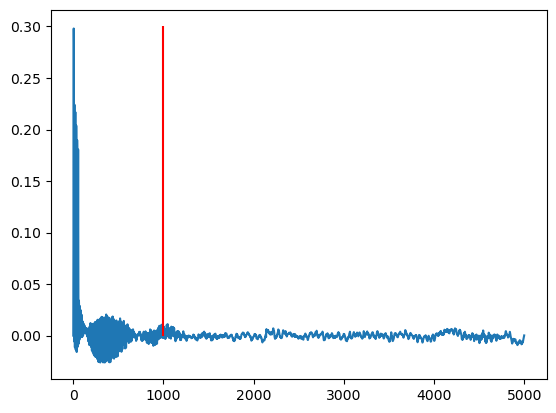

In [70]:
plt.plot(data[:5000])
plt.vlines(1000, 0.0, 0.3, color='red')

Text(0.5, 1.0, 'With artefacts, long')

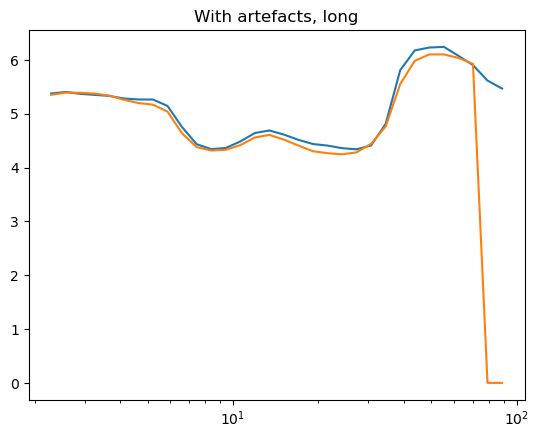

In [71]:
plt.semilogx(freqs, bis_mle, label='MLE')
plt.semilogx(freqs, bis_em.get(), label='EM')
plt.title('With artefacts, long')

Text(0.5, 1.0, 'No artefacts, long')

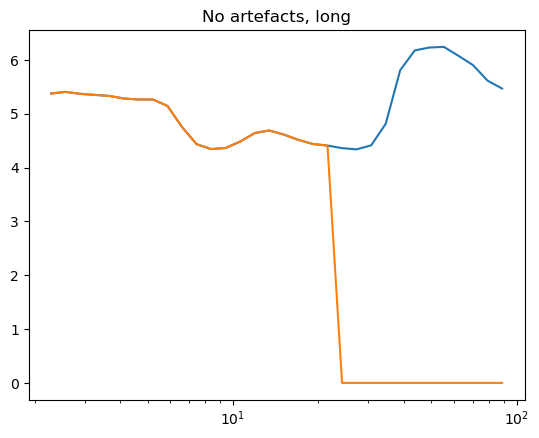

In [48]:
plt.semilogx(freqs, bis_mle)
plt.semilogx(freqs, bis_em.get())
plt.title('No artefacts, long')